In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animefacedataset/images/35715_2011.jpg


In [40]:
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [41]:
# # Detect TPU, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [42]:
batch_size: int = 128

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/animefacedataset', label_mode=None, 
    image_size=(64,64), batch_size=batch_size
)

train_dataset = train_dataset.map(lambda x: (x/127.5)-1)

Found 63565 files belonging to 1 classes.


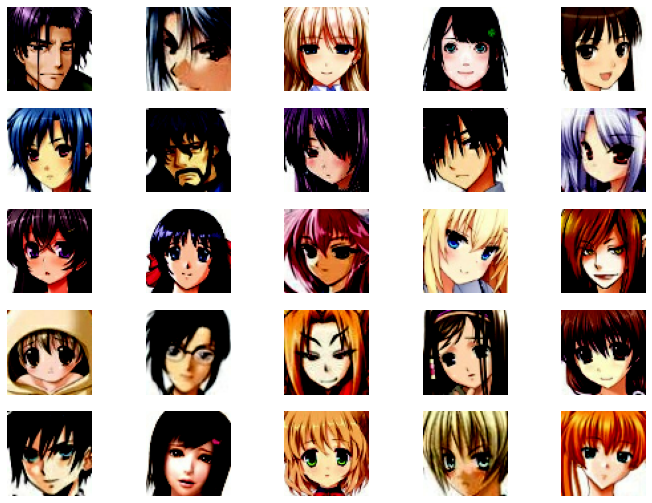

In [43]:
plt.figure(figsize=(12,9))

for images in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.axis('off')


Image shape:  (64, 64, 3)


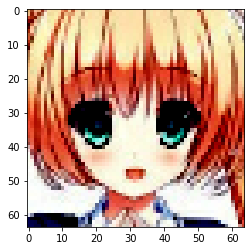

In [44]:
for batch in train_dataset:
    plt.imshow(batch[0])
    print("Image shape: ", batch[0].shape)
    break

In [45]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [46]:
def generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(100, )))
    model.add(layers.Dense(4*4*256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",
                                    kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same",
                                    kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same",
                                    kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh',
                                    kernel_initializer=init_weights_kernel, use_bias=False))
    
    return model

generator = generator_model()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_19 (Batc (None, 4096)              16384     
_________________________________________________________________
re_lu_9 (ReLU)               (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 8, 8, 128)        

In [47]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image.shape

TensorShape([1, 64, 64, 3])

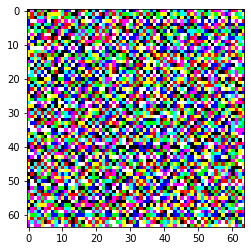

In [48]:
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

In [49]:
def discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(32, kernel_size=3, strides = 2, padding="same", input_shape =[64, 64, 3],
                           kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, kernel_size=3, strides = 2, padding="same",
                           kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides = 2, padding="same",
                           kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides = 2, padding="same",
                           kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
#     model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18432     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 17, 17, 64)       

In [50]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.5000004]], shape=(1, 1), dtype=float32)


In [51]:
bce = tf.keras.losses.BinaryCrossentropy()

In [52]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [53]:
generator_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [54]:
# checkpoint_dir = "data-cnn-gan/color/training_checkpoints"
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(generator_optimizer = generator_opt,
#                                  discriminator_optimizer = discriminator_opt,
#                                  generator=generator,
#                                  discriminator=discriminator
#                                  )

In [55]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [56]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
    
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [57]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')
    
#     plt.savefig('data-cnn-gan/gray/images/image_at_epoch {:04d}.png'.format(epoch))
    plt.show()

In [58]:
from sklearn.model_selection import train_test_split


def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        
        num_batches = len(dataset)
        
        print(f"Training started with epoch {epoch+1} with {num_batches} batches...")
        
        total_gen_loss, total_disc_loss = 0, 0
        
        for batch in dataset:
            gen_loss, disc_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
        
        print(f"Epoch: {epoch+1}: Generator loss: {gen_loss: 3f}, Discriminator loss: {disc_loss: 3f}, Real Score: {real_score: 3f}. Fake Score: {fake_score: 3f}")
        
        generate_and_plot_images(generator, epoch+1, seed)
        
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)
        
#         if (epoch+1) % 10 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch: {epoch+1} is {time.time() - start} seconds")
        
    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list
        

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 497 batches...
Epoch: 1: Generator loss:  5.165168, Discriminator loss:  0.123815, Real Score:  0.944277. Fake Score:  0.020033


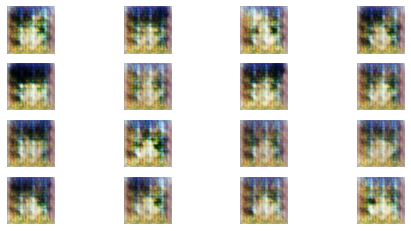

  2%|▏         | 1/50 [01:00<49:40, 60.83s/it]

Time for epoch: 1 is 60.826133012771606 seconds
Training started with epoch 2 with 497 batches...
Epoch: 2: Generator loss:  5.420653, Discriminator loss:  0.215983, Real Score:  0.877037. Fake Score:  0.023193


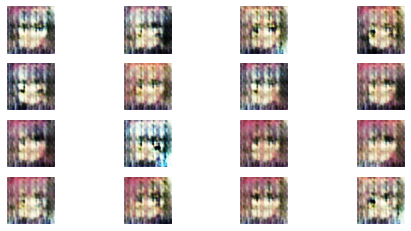

  4%|▍         | 2/50 [01:55<45:59, 57.49s/it]

Time for epoch: 2 is 55.147953748703 seconds
Training started with epoch 3 with 497 batches...
Epoch: 3: Generator loss:  3.396200, Discriminator loss:  0.253409, Real Score:  0.925137. Fake Score:  0.112101


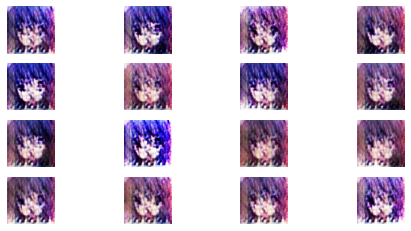

  6%|▌         | 3/50 [02:49<43:47, 55.90s/it]

Time for epoch: 3 is 54.010977029800415 seconds
Training started with epoch 4 with 497 batches...
Epoch: 4: Generator loss:  2.151201, Discriminator loss:  0.553321, Real Score:  0.849369. Fake Score:  0.232274


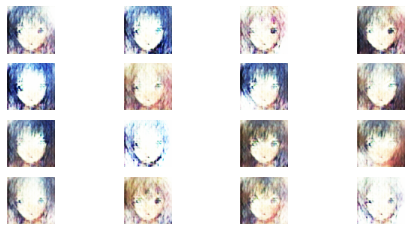

  8%|▊         | 4/50 [03:46<42:56, 56.01s/it]

Time for epoch: 4 is 56.1871874332428 seconds
Training started with epoch 5 with 497 batches...
Epoch: 5: Generator loss:  0.594556, Discriminator loss:  1.396880, Real Score:  0.958157. Fake Score:  0.635687


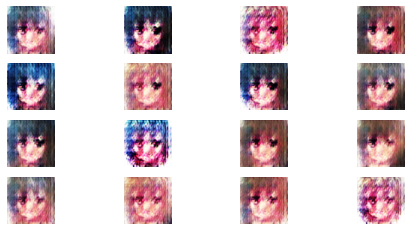

 10%|█         | 5/50 [04:40<41:37, 55.50s/it]

Time for epoch: 5 is 54.58478856086731 seconds
Training started with epoch 6 with 497 batches...
Epoch: 6: Generator loss:  2.728150, Discriminator loss:  0.317888, Real Score:  0.894978. Fake Score:  0.143994


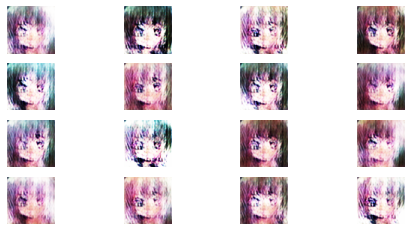

 12%|█▏        | 6/50 [05:35<40:31, 55.27s/it]

Time for epoch: 6 is 54.81982207298279 seconds
Training started with epoch 7 with 497 batches...
Epoch: 7: Generator loss:  4.302269, Discriminator loss:  0.607469, Real Score:  0.691543. Fake Score:  0.039758


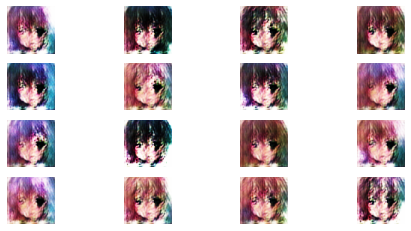

 14%|█▍        | 7/50 [06:29<39:22, 54.93s/it]

Time for epoch: 7 is 54.23372673988342 seconds
Training started with epoch 8 with 497 batches...
Epoch: 8: Generator loss:  3.894413, Discriminator loss:  0.367343, Real Score:  0.796902. Fake Score:  0.056358


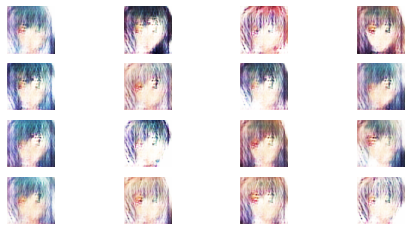

 16%|█▌        | 8/50 [07:23<38:11, 54.55s/it]

Time for epoch: 8 is 53.74287223815918 seconds
Training started with epoch 9 with 497 batches...
Epoch: 9: Generator loss:  4.856016, Discriminator loss:  0.177289, Real Score:  0.896985. Fake Score:  0.031700


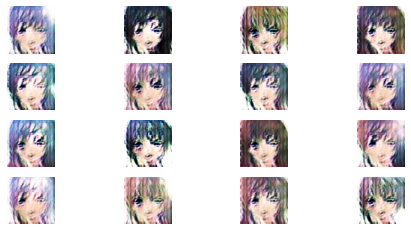

 18%|█▊        | 9/50 [08:17<37:10, 54.40s/it]

Time for epoch: 9 is 54.0634651184082 seconds
Training started with epoch 10 with 497 batches...
Epoch: 10: Generator loss:  2.642316, Discriminator loss:  0.328434, Real Score:  0.985342. Fake Score:  0.195055


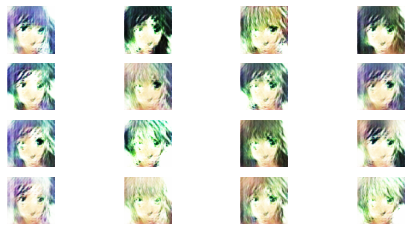

 20%|██        | 10/50 [09:12<36:18, 54.46s/it]

Time for epoch: 10 is 54.59105825424194 seconds
Training started with epoch 11 with 497 batches...
Epoch: 11: Generator loss:  1.852925, Discriminator loss:  0.508632, Real Score:  0.955145. Fake Score:  0.285881


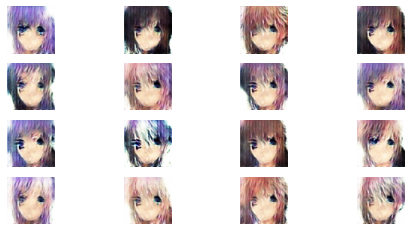

 22%|██▏       | 11/50 [10:05<35:10, 54.11s/it]

Time for epoch: 11 is 53.3205840587616 seconds
Training started with epoch 12 with 497 batches...
Epoch: 12: Generator loss:  1.881555, Discriminator loss:  0.649267, Real Score:  0.973881. Fake Score:  0.336843


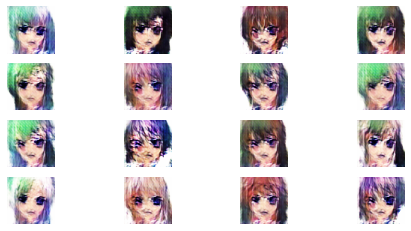

 24%|██▍       | 12/50 [10:59<34:15, 54.10s/it]

Time for epoch: 12 is 54.059829235076904 seconds
Training started with epoch 13 with 497 batches...
Epoch: 13: Generator loss:  2.441762, Discriminator loss:  0.604445, Real Score:  0.802303. Fake Score:  0.202161


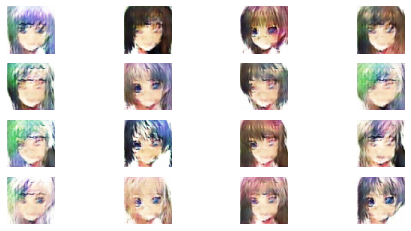

 26%|██▌       | 13/50 [11:54<33:27, 54.27s/it]

Time for epoch: 13 is 54.655025243759155 seconds
Training started with epoch 14 with 497 batches...
Epoch: 14: Generator loss:  4.005548, Discriminator loss:  0.377136, Real Score:  0.792905. Fake Score:  0.054908


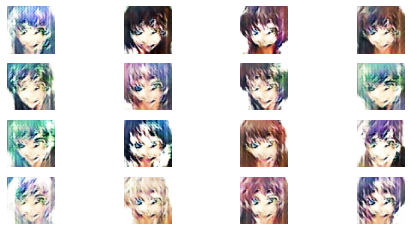

 28%|██▊       | 14/50 [12:47<32:25, 54.04s/it]

Time for epoch: 14 is 53.5296413898468 seconds
Training started with epoch 15 with 497 batches...
Epoch: 15: Generator loss:  2.675257, Discriminator loss:  0.383399, Real Score:  0.917985. Fake Score:  0.186934


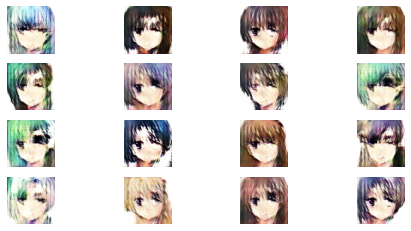

 30%|███       | 15/50 [13:41<31:27, 53.94s/it]

Time for epoch: 15 is 53.68260455131531 seconds
Training started with epoch 16 with 497 batches...
Epoch: 16: Generator loss:  2.751657, Discriminator loss:  0.473642, Real Score:  0.776471. Fake Score:  0.136352


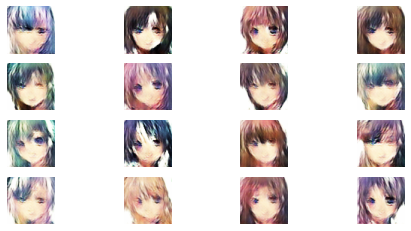

 32%|███▏      | 16/50 [14:35<30:36, 54.02s/it]

Time for epoch: 16 is 54.231229066848755 seconds
Training started with epoch 17 with 497 batches...
Epoch: 17: Generator loss:  2.404455, Discriminator loss:  0.509266, Real Score:  0.811357. Fake Score:  0.178556


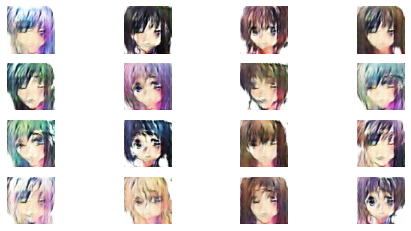

 34%|███▍      | 17/50 [15:29<29:41, 54.00s/it]

Time for epoch: 17 is 53.933841705322266 seconds
Training started with epoch 18 with 497 batches...
Epoch: 18: Generator loss:  3.607089, Discriminator loss:  0.377850, Real Score:  0.788870. Fake Score:  0.066100


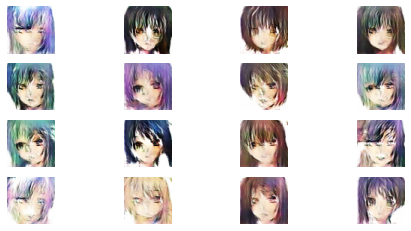

 36%|███▌      | 18/50 [16:24<28:55, 54.22s/it]

Time for epoch: 18 is 54.7412691116333 seconds
Training started with epoch 19 with 497 batches...
Epoch: 19: Generator loss:  2.639196, Discriminator loss:  0.635589, Real Score:  0.754633. Fake Score:  0.174375


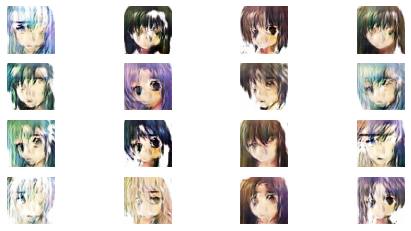

 38%|███▊      | 19/50 [17:18<27:59, 54.18s/it]

Time for epoch: 19 is 54.06619882583618 seconds
Training started with epoch 20 with 497 batches...
Epoch: 20: Generator loss:  2.677094, Discriminator loss:  0.489787, Real Score:  0.818423. Fake Score:  0.163922


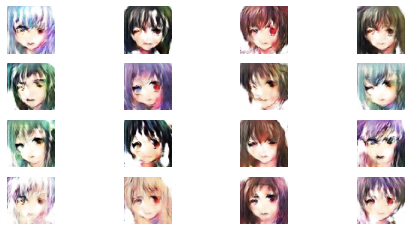

 40%|████      | 20/50 [18:12<27:06, 54.22s/it]

Time for epoch: 20 is 54.31292963027954 seconds
Training started with epoch 21 with 497 batches...
Epoch: 21: Generator loss:  4.129077, Discriminator loss:  0.343859, Real Score:  0.794894. Fake Score:  0.056233


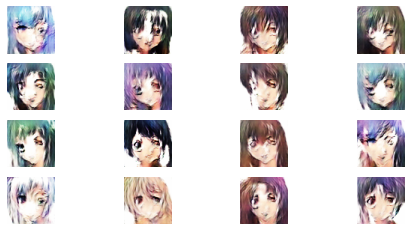

 42%|████▏     | 21/50 [19:06<26:05, 53.97s/it]

Time for epoch: 21 is 53.39594221115112 seconds
Training started with epoch 22 with 497 batches...
Epoch: 22: Generator loss:  4.176580, Discriminator loss:  0.507277, Real Score:  0.719625. Fake Score:  0.051176


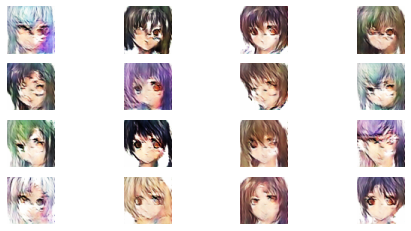

 44%|████▍     | 22/50 [20:00<25:10, 53.94s/it]

Time for epoch: 22 is 53.87189698219299 seconds
Training started with epoch 23 with 497 batches...
Epoch: 23: Generator loss:  4.017267, Discriminator loss:  0.933889, Real Score:  0.548833. Fake Score:  0.057875


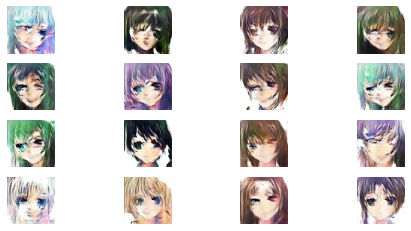

 46%|████▌     | 23/50 [20:53<24:14, 53.89s/it]

Time for epoch: 23 is 53.75287938117981 seconds
Training started with epoch 24 with 497 batches...
Epoch: 24: Generator loss:  2.492941, Discriminator loss:  0.555584, Real Score:  0.768145. Fake Score:  0.179096


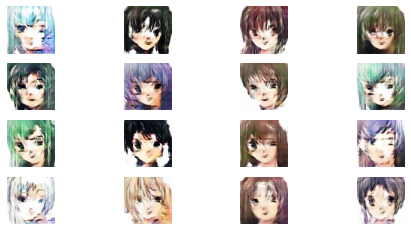

 48%|████▊     | 24/50 [21:47<23:22, 53.95s/it]

Time for epoch: 24 is 54.09992575645447 seconds
Training started with epoch 25 with 497 batches...
Epoch: 25: Generator loss:  3.190435, Discriminator loss:  0.421892, Real Score:  0.789090. Fake Score:  0.097828


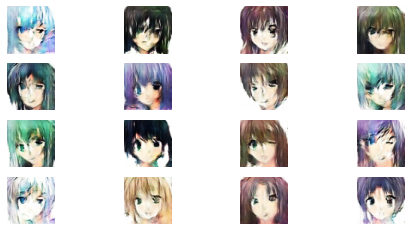

 50%|█████     | 25/50 [22:42<22:31, 54.07s/it]

Time for epoch: 25 is 54.33170962333679 seconds
Training started with epoch 26 with 497 batches...
Epoch: 26: Generator loss:  3.485134, Discriminator loss:  0.350438, Real Score:  0.808578. Fake Score:  0.068051


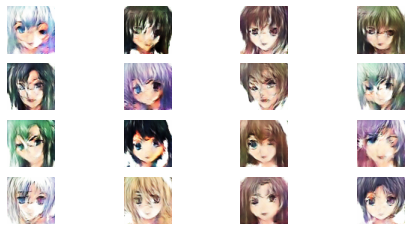

 52%|█████▏    | 26/50 [23:36<21:36, 54.04s/it]

Time for epoch: 26 is 53.96831226348877 seconds
Training started with epoch 27 with 497 batches...
Epoch: 27: Generator loss:  1.980355, Discriminator loss:  0.494579, Real Score:  0.885254. Fake Score:  0.238158


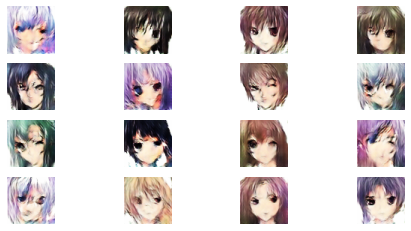

 54%|█████▍    | 27/50 [24:30<20:41, 53.99s/it]

Time for epoch: 27 is 53.87138915061951 seconds
Training started with epoch 28 with 497 batches...
Epoch: 28: Generator loss:  1.635957, Discriminator loss:  0.574983, Real Score:  0.927917. Fake Score:  0.314826


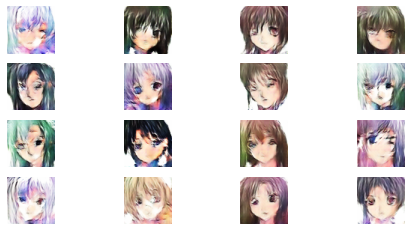

 56%|█████▌    | 28/50 [25:24<19:52, 54.20s/it]

Time for epoch: 28 is 54.69551610946655 seconds
Training started with epoch 29 with 497 batches...
Epoch: 29: Generator loss:  3.818250, Discriminator loss:  0.740775, Real Score:  0.619413. Fake Score:  0.062432


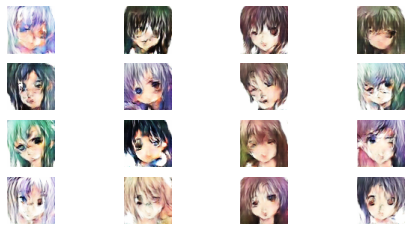

 58%|█████▊    | 29/50 [26:18<18:55, 54.06s/it]

Time for epoch: 29 is 53.72194504737854 seconds
Training started with epoch 30 with 497 batches...
Epoch: 30: Generator loss:  0.709476, Discriminator loss:  1.588100, Real Score:  0.775517. Fake Score:  0.595832


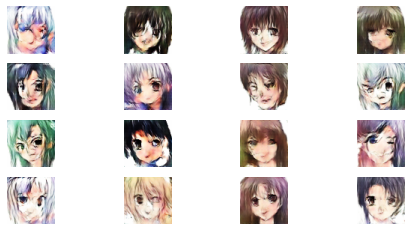

 60%|██████    | 30/50 [27:12<17:59, 53.96s/it]

Time for epoch: 30 is 53.726216554641724 seconds
Training started with epoch 31 with 497 batches...
Epoch: 31: Generator loss:  2.184419, Discriminator loss:  0.468005, Real Score:  0.879319. Fake Score:  0.215679


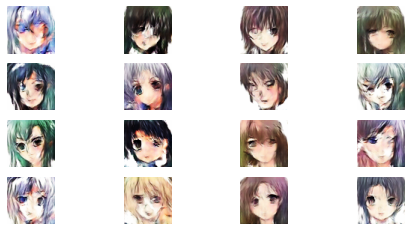

 62%|██████▏   | 31/50 [28:06<17:06, 54.02s/it]

Time for epoch: 31 is 54.16211915016174 seconds
Training started with epoch 32 with 497 batches...
Epoch: 32: Generator loss:  3.397459, Discriminator loss:  0.366432, Real Score:  0.809740. Fake Score:  0.082593


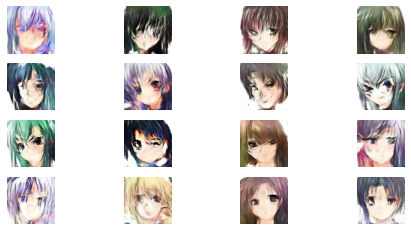

 64%|██████▍   | 32/50 [29:00<16:13, 54.07s/it]

Time for epoch: 32 is 54.198086738586426 seconds
Training started with epoch 33 with 497 batches...
Epoch: 33: Generator loss:  1.851086, Discriminator loss:  0.612134, Real Score:  0.838733. Fake Score:  0.267736


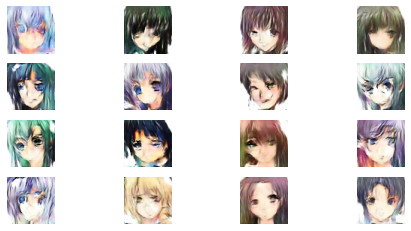

 66%|██████▌   | 33/50 [29:54<15:17, 53.95s/it]

Time for epoch: 33 is 53.65501141548157 seconds
Training started with epoch 34 with 497 batches...
Epoch: 34: Generator loss:  2.033952, Discriminator loss:  0.559269, Real Score:  0.846256. Fake Score:  0.245978


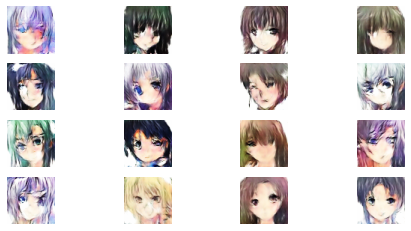

 68%|██████▊   | 34/50 [30:48<14:22, 53.91s/it]

Time for epoch: 34 is 53.80677652359009 seconds
Training started with epoch 35 with 497 batches...
Epoch: 35: Generator loss:  2.416074, Discriminator loss:  0.433958, Real Score:  0.884018. Fake Score:  0.193703


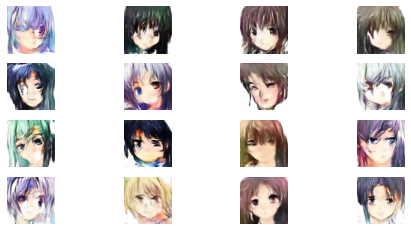

 70%|███████   | 35/50 [31:41<13:27, 53.83s/it]

Time for epoch: 35 is 53.65434694290161 seconds
Training started with epoch 36 with 497 batches...
Epoch: 36: Generator loss:  1.916339, Discriminator loss:  0.473872, Real Score:  0.946108. Fake Score:  0.268630


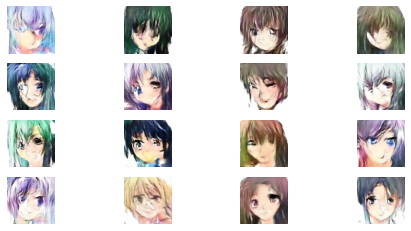

 72%|███████▏  | 36/50 [32:35<12:33, 53.84s/it]

Time for epoch: 36 is 53.842082023620605 seconds
Training started with epoch 37 with 497 batches...
Epoch: 37: Generator loss:  3.630883, Discriminator loss:  0.555770, Real Score:  0.695872. Fake Score:  0.076093


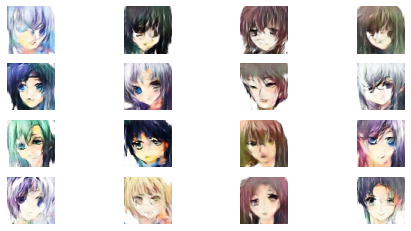

 74%|███████▍  | 37/50 [33:29<11:40, 53.88s/it]

Time for epoch: 37 is 53.97455430030823 seconds
Training started with epoch 38 with 497 batches...
Epoch: 38: Generator loss:  2.043858, Discriminator loss:  0.823095, Real Score:  0.700987. Fake Score:  0.227666


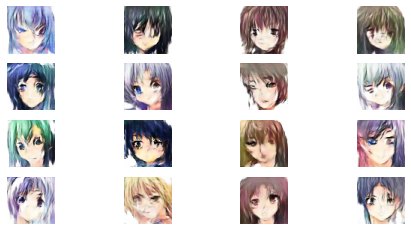

 76%|███████▌  | 38/50 [34:24<10:50, 54.21s/it]

Time for epoch: 38 is 54.997849464416504 seconds
Training started with epoch 39 with 497 batches...
Epoch: 39: Generator loss:  3.642128, Discriminator loss:  0.458809, Real Score:  0.769978. Fake Score:  0.081121


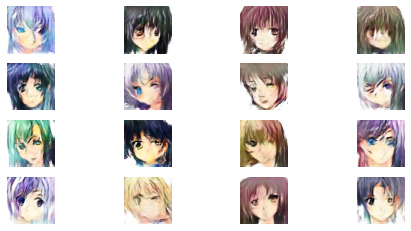

 78%|███████▊  | 39/50 [35:23<10:13, 55.78s/it]

Time for epoch: 39 is 59.422569274902344 seconds
Training started with epoch 40 with 497 batches...
Epoch: 40: Generator loss:  1.424282, Discriminator loss:  0.632142, Real Score:  0.978807. Fake Score:  0.357058


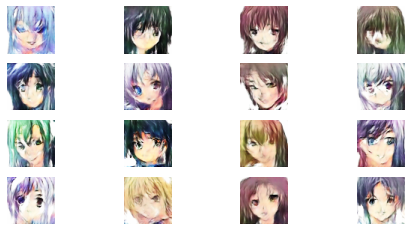

 80%|████████  | 40/50 [36:16<09:09, 54.93s/it]

Time for epoch: 40 is 52.94260001182556 seconds
Training started with epoch 41 with 497 batches...
Epoch: 41: Generator loss:  4.766791, Discriminator loss:  0.407323, Real Score:  0.728446. Fake Score:  0.026699


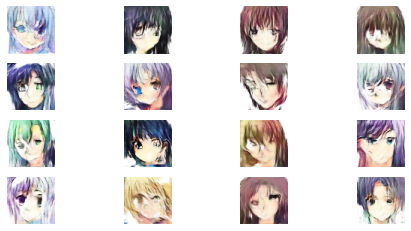

 82%|████████▏ | 41/50 [37:10<08:10, 54.45s/it]

Time for epoch: 41 is 53.34206557273865 seconds
Training started with epoch 42 with 497 batches...
Epoch: 42: Generator loss:  1.454095, Discriminator loss:  0.673030, Real Score:  0.968445. Fake Score:  0.373951


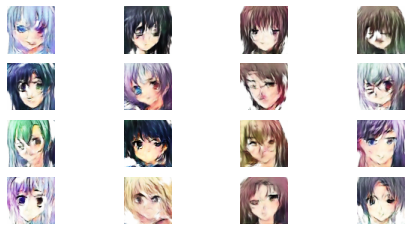

 84%|████████▍ | 42/50 [38:03<07:12, 54.09s/it]

Time for epoch: 42 is 53.25229501724243 seconds
Training started with epoch 43 with 497 batches...
Epoch: 43: Generator loss:  3.909600, Discriminator loss:  0.351598, Real Score:  0.797898. Fake Score:  0.057307


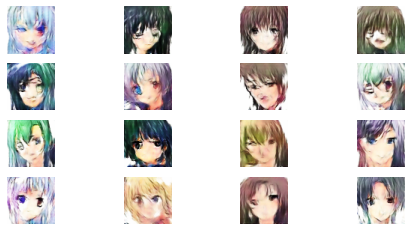

 86%|████████▌ | 43/50 [38:57<06:18, 54.14s/it]

Time for epoch: 43 is 54.240150451660156 seconds
Training started with epoch 44 with 497 batches...
Epoch: 44: Generator loss:  3.457088, Discriminator loss:  0.213963, Real Score:  0.906399. Fake Score:  0.085276


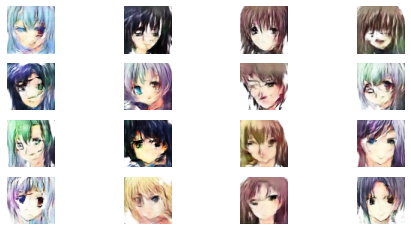

 88%|████████▊ | 44/50 [39:53<05:27, 54.58s/it]

Time for epoch: 44 is 55.62477207183838 seconds
Training started with epoch 45 with 497 batches...
Epoch: 45: Generator loss:  1.313369, Discriminator loss:  0.752888, Real Score:  0.867127. Fake Score:  0.371300


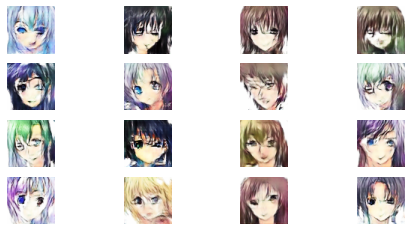

 90%|█████████ | 45/50 [40:49<04:35, 55.03s/it]

Time for epoch: 45 is 56.05948328971863 seconds
Training started with epoch 46 with 497 batches...
Epoch: 46: Generator loss:  2.028856, Discriminator loss:  0.553332, Real Score:  0.829441. Fake Score:  0.238333


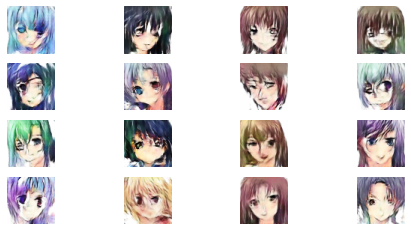

 92%|█████████▏| 46/50 [41:45<03:41, 55.35s/it]

Time for epoch: 46 is 56.08866620063782 seconds
Training started with epoch 47 with 497 batches...
Epoch: 47: Generator loss:  3.406761, Discriminator loss:  0.328108, Real Score:  0.834537. Fake Score:  0.080796


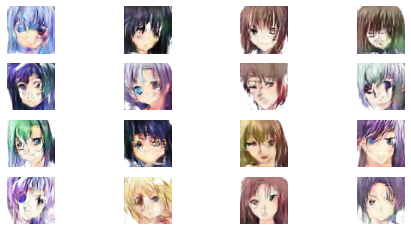

 94%|█████████▍| 47/50 [42:39<02:44, 54.88s/it]

Time for epoch: 47 is 53.775654315948486 seconds
Training started with epoch 48 with 497 batches...
Epoch: 48: Generator loss:  4.699451, Discriminator loss:  0.286695, Real Score:  0.838641. Fake Score:  0.041168


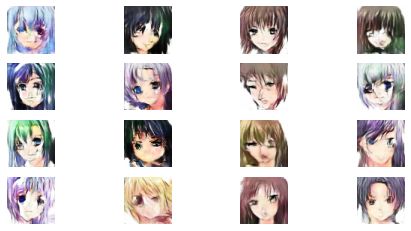

 96%|█████████▌| 48/50 [43:32<01:48, 54.41s/it]

Time for epoch: 48 is 53.31717371940613 seconds
Training started with epoch 49 with 497 batches...
Epoch: 49: Generator loss:  3.463335, Discriminator loss:  0.197321, Real Score:  0.921681. Fake Score:  0.088877


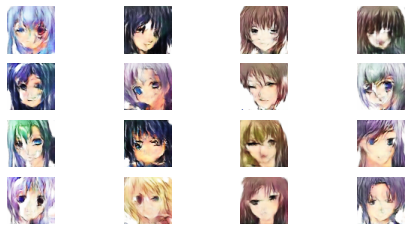

 98%|█████████▊| 49/50 [44:26<00:54, 54.12s/it]

Time for epoch: 49 is 53.44744539260864 seconds
Training started with epoch 50 with 497 batches...
Epoch: 50: Generator loss:  1.356987, Discriminator loss:  1.041944, Real Score:  0.764675. Fake Score:  0.388298


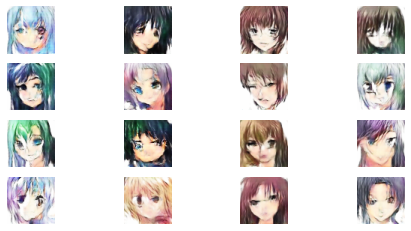

100%|██████████| 50/50 [45:22<00:00, 54.44s/it]

Time for epoch: 50 is 56.09946799278259 seconds


In [59]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

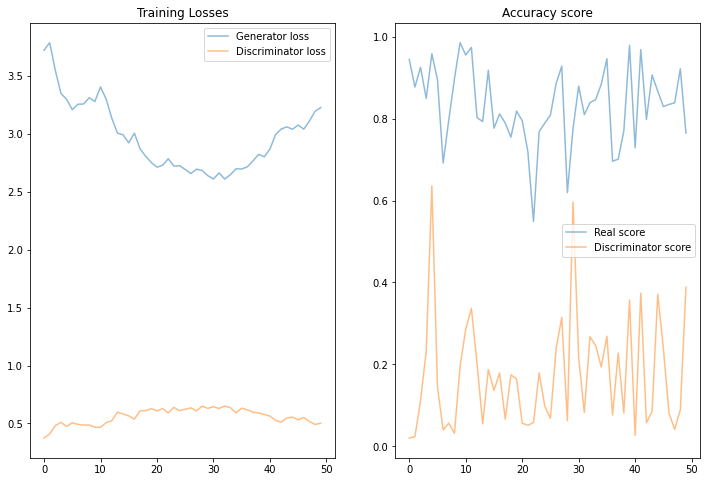

In [60]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(gen_loss_epochs, label="Generator loss", alpha=0.5)
ax1.plot(disc_loss_epochs, label="Discriminator loss", alpha=0.5)
ax1.legend()

ax1.set_title("Training Losses")
ax2.plot(real_score_list, label="Real score", alpha=0.5)
ax2.plot(fake_score_list, label="Discriminator score", alpha=0.5)
ax2.set_title("Accuracy score")

ax2.legend()

